In [21]:
!pip3 install pillow

In [73]:
!pip3 install opencv-python

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/c7/ec/9dabb6a9abfdebb3c45b0cc52dec901caafef2b2c7e7d6a839ed86d81e91/opencv_python-4.9.0.80-cp37-abi3-win_amd64.whl.metadata
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ------

In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import optimizers, layers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, Add, Input, Activation, ZeroPadding2D, Flatten, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K


# from jupyterthemes import jtplot
# jtplot.style(theme = 'monokai', context='notebook', ticks = True, grid = False)

In [2]:
Xray_train_Directory = 'Chest_X_Ray_project_data/train'
os.listdir(Xray_train_Directory)

['0', '1', '2', '3']

In [3]:
#Use image generator to generate tensor images data and normalize them
#use 20% of the data for cross-validation
image_generator = ImageDataGenerator(rescale = 1/255, validation_split = 0.2)

In [4]:
#generate batches of 40 images
#Total number of images = 133*4(# of classes) = 532
#Traininf is 428 (80%) and validation is 104 (20%)
#Perform Shuffling and image resizing
train_generator = image_generator.flow_from_directory(batch_size = 40,
                                                     directory = Xray_train_Directory,
                                                     shuffle = True,
                                                     target_size = (256,256),
                                                     class_mode = 'categorical',
                                                     subset='training')

Found 428 images belonging to 4 classes.


In [5]:
valid_generator = image_generator.flow_from_directory(batch_size = 40,
                                                     directory = Xray_train_Directory,
                                                     shuffle = True,
                                                     target_size = (256,256),
                                                     class_mode = 'categorical',
                                                     subset='validation')

Found 104 images belonging to 4 classes.


In [6]:
train_images, train_labels = next(train_generator)

In [8]:
train_labels

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]],

In [9]:
label_names = {0: 'Covid-19', 1: 'Normal', 2: 'Viral Pneumonia', 3: 'Bacterial Pneumonia'}

In [10]:
train_labels.shape

(40, 4)

In [11]:
print(train_images.shape)
len(train_images)

(40, 256, 256, 3)


40

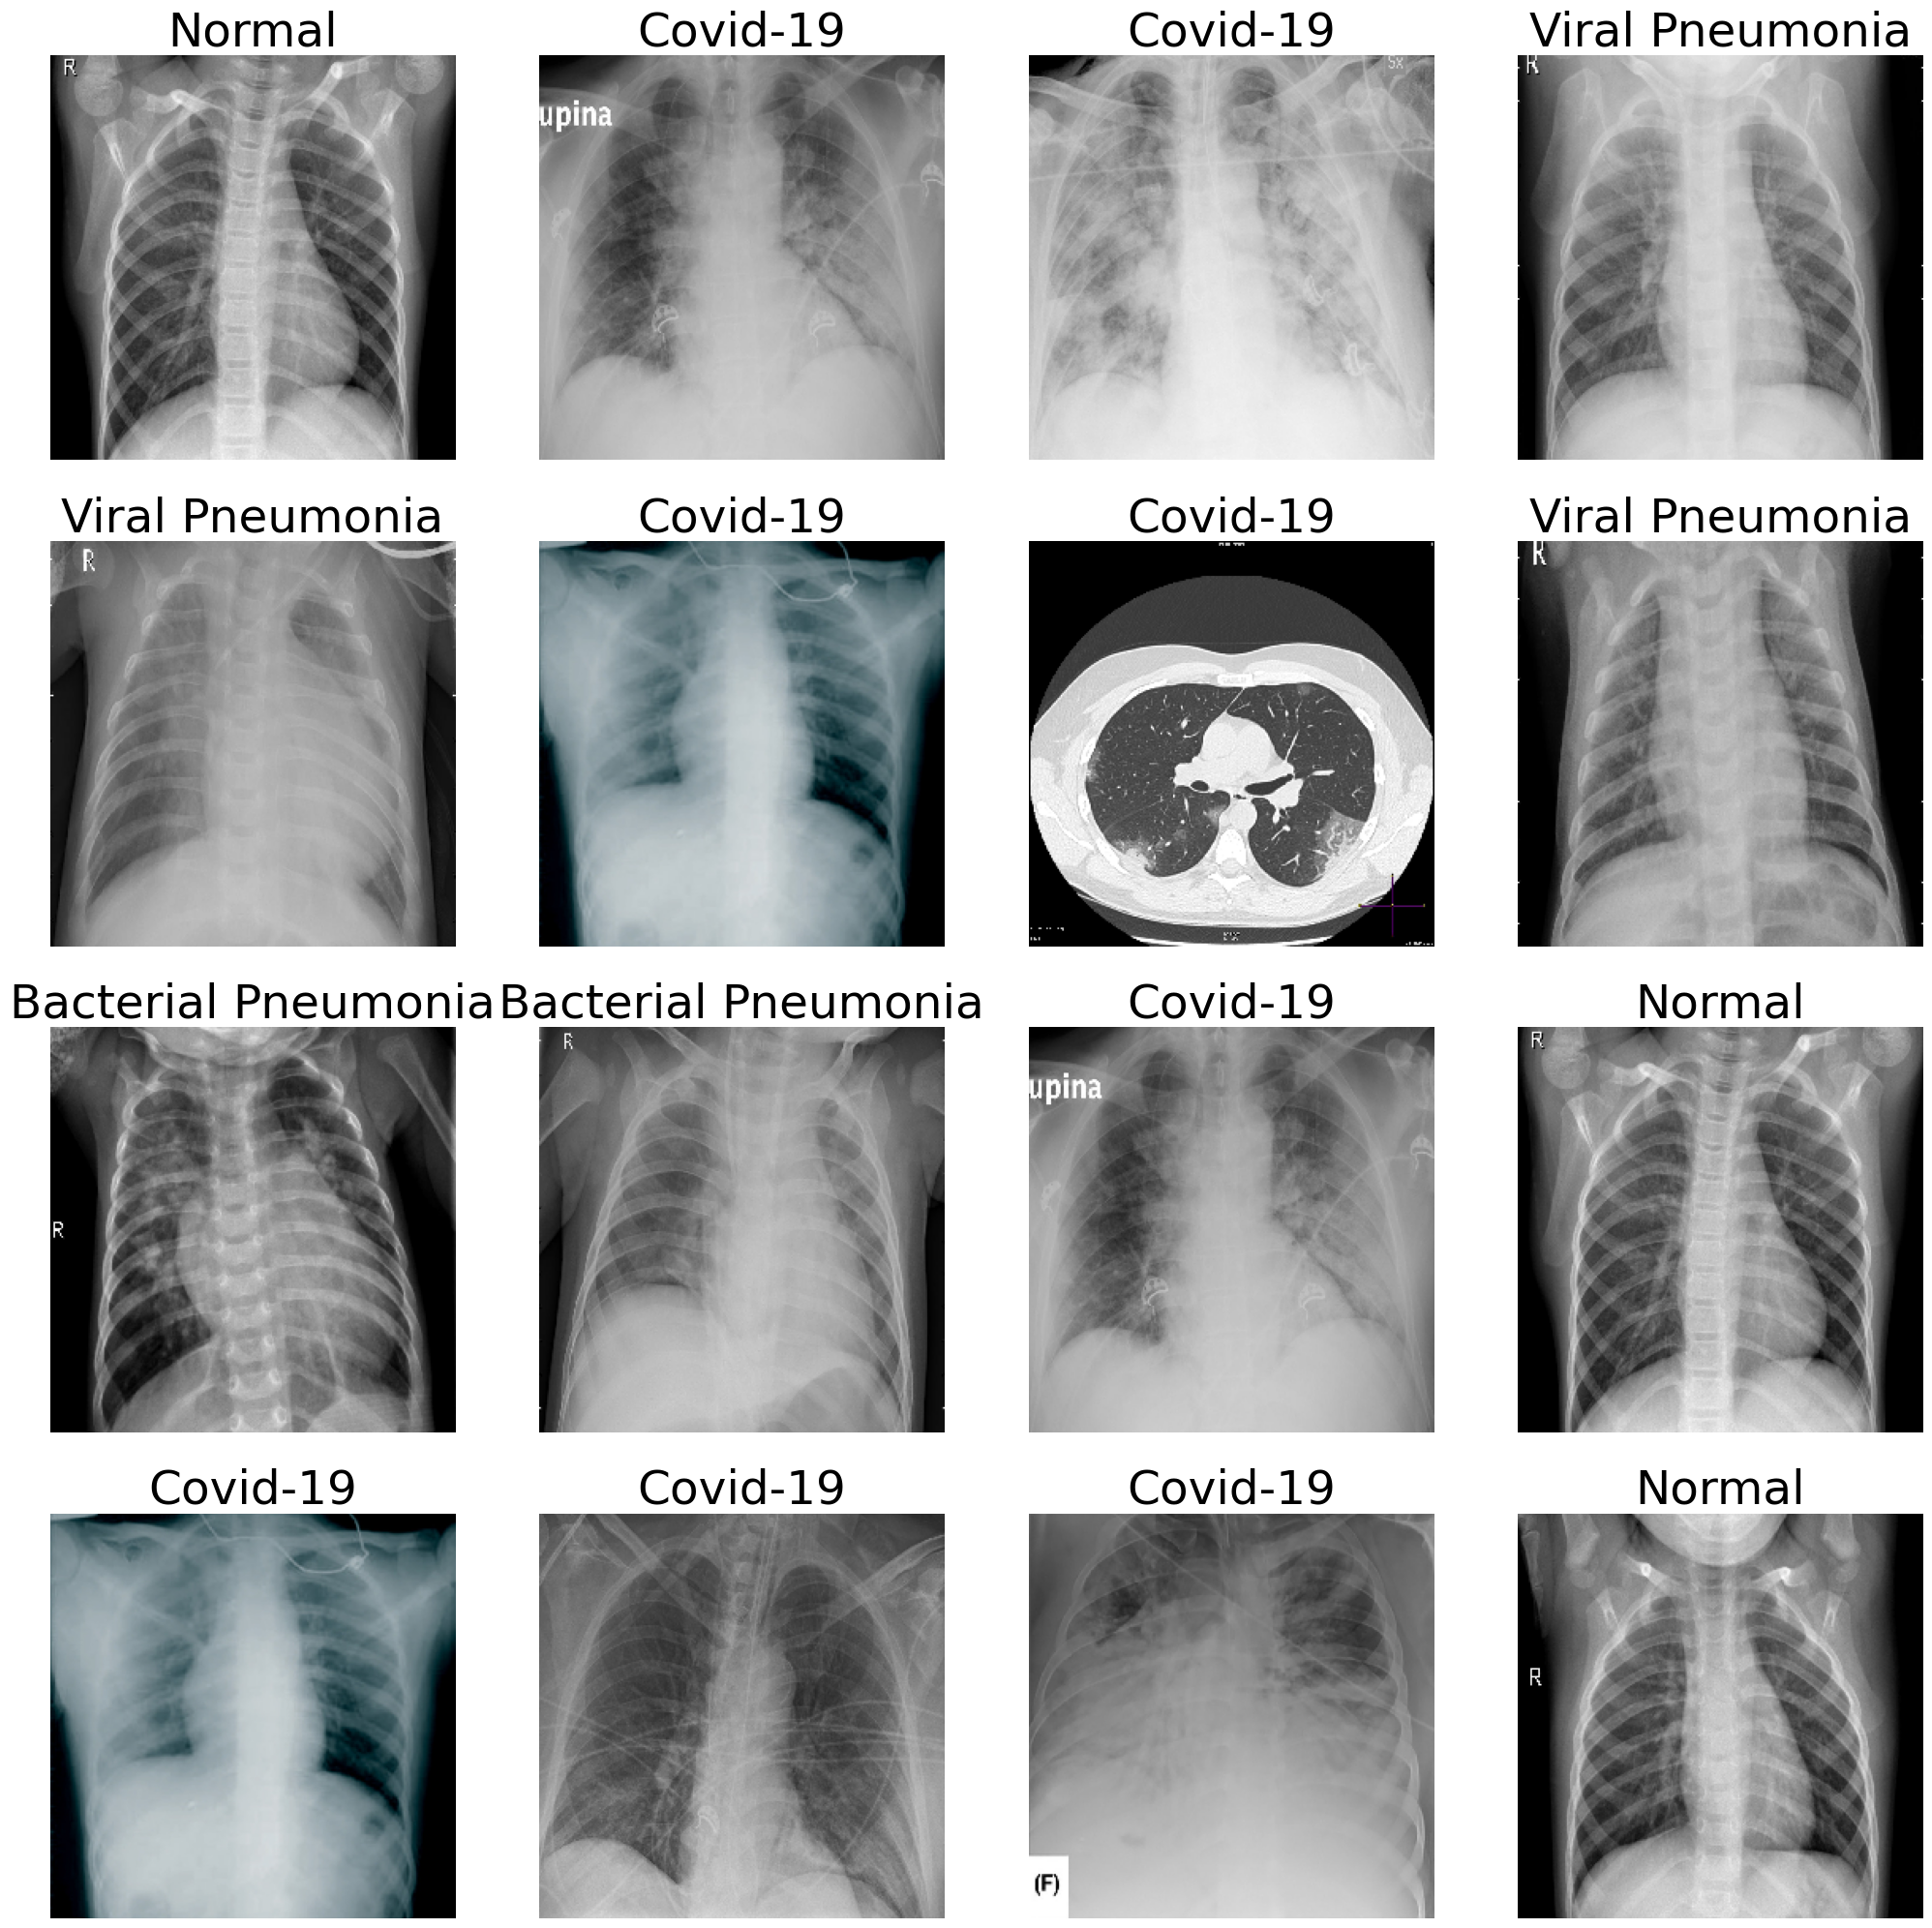

In [12]:
w_grid = 4
l_grid = 4

fig, axes = plt.subplots(l_grid, w_grid, figsize=(25, 25)) 

axes = axes.ravel()

for i in np.arange(0, w_grid * l_grid):
    j = np.random.randint(0, len(train_images))
    axes[i].imshow(train_images[j])
    axes[i].set_title(label_names[np.argmax(train_labels[j])], fontsize = 35)
    axes[i].axis('off')

## Creating Model

In [13]:
pre_trained_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))

In [9]:
pre_trained_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [14]:
#Freeze the model upto the last stage - 4 and re-training stage -5
for layer in pre_trained_model.layers[:-10]:
    layers.trainable = False

In [39]:
#Adding layers to our pre_trained ResNet50 model

head_model = pre_trained_model.output
head_model = layers.AveragePooling2D(pool_size=(4,4))(head_model)
head_model = layers.Flatten(name="flatten")(head_model)


# Test = 0.7 and val = .7875
# head_model = Dense(512, activation='relu')(head_model)
# head_model = layers.Dropout(0.3)(head_model)
# head_model = Dense(256, activation='relu')(head_model)
# head_model = layers.Dropout(0.2)(head_model)
# head_model = Dense(64, activation='relu')(head_model)
# head_model = layers.Dropout(0.1)(head_model)
# head_model = Dense(4, activation='softmax')(head_model)

# Test = 0.725
# head_model = Dense(1028, activation='relu')(head_model)
# head_model = layers.Dropout(0.4)(head_model)
# head_model = Dense(400, activation='relu')(head_model)
# head_model = layers.Dropout(0.3)(head_model)
# head_model = Dense(56, activation='relu')(head_model)
# head_model = layers.Dropout(0.1)(head_model)
# head_model = Dense(4, activation='softmax')(head_model)


model = Model(inputs = pre_trained_model.input, outputs = head_model)

In [40]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

## Training Model

In [41]:
#model.compile(optimizer=optimizers.legacy.RMSprop(learning_rate = 1e-4, decay=1e-6), loss = 'categorical_crossentropy', metrics=['acc'])
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['acc'])

In [42]:
#Using early stopping to exit training if validation loss is not decreasing even after certain epochs
earlystopping = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience=10)


#Save the Best model with loweste vaidation loss among every epochs
checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose = 1, save_best_only=True)

In [43]:
train_generator = image_generator.flow_from_directory(batch_size = 5,
                                                     directory = Xray_train_Directory,
                                                     shuffle = True,
                                                     target_size = (256,256),
                                                     class_mode = 'categorical',
                                                     subset='training')

valid_generator = image_generator.flow_from_directory(batch_size = 5,
                                                     directory = Xray_train_Directory,
                                                     shuffle = True,
                                                     target_size = (256,256),
                                                     class_mode = 'categorical',
                                                     subset='validation')

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [48]:
history = model.fit(train_generator, steps_per_epoch = train_generator.n // 5, epochs = 30, validation_data = valid_generator,  validation_steps= valid_generator.n // 5, callbacks=[checkpointer, earlystopping])

Epoch 1/30
85/85 [==============================] - ETA: 0s - loss: 0.7462 - acc: 0.7069
Epoch 1: val_loss improved from inf to 1.29771, saving model to weights.hdf5


C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 234s 3s/step - loss: 0.7462 - acc: 0.7069 - val_loss: 1.2977 - val_acc: 0.5800
Epoch 2/30
85/85 [==============================] - ETA: 0s - loss: 0.5628 - acc: 0.7825
Epoch 2: val_loss did not improve from 1.29771
85/85 [==============================] - 198s 2s/step - loss: 0.5628 - acc: 0.7825 - val_loss: 1.9056 - val_acc: 0.7200
Epoch 3/30
85/85 [==============================] - ETA: 0s - loss: 0.4557 - acc: 0.8582
Epoch 3: val_loss did not improve from 1.29771
85/85 [==============================] - 212s 2s/step - loss: 0.4557 - acc: 0.8582 - val_loss: 2.7109 - val_acc: 0.4500
Epoch 4/30
85/85 [==============================] - ETA: 0s - loss: 0.3729 - acc: 0.8723
Epoch 4: val_loss did not improve from 1.29771
85/85 [==============================] - 277s 3s/step - loss: 0.3729 - acc: 0.8723 - val_loss: 1.9350 - val_acc: 0.6100
Epoch 5/30
85/85 [==============================] - ETA: 0s - loss: 0.3731 - acc: 0.8794
Epoch 5: val_loss impro

In [199]:
#Serialoze model to json
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)

#Serialize weights to HDF5
model.save_weights('model.h5')
print("Saved model to the disk")

Saved model to the disk


In [ ]:
# load json and create model

from tensorflow.keras.models import model_from_json

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model.h5")
print("Loaded model from disk")


## Performance Analysis and Testing Model

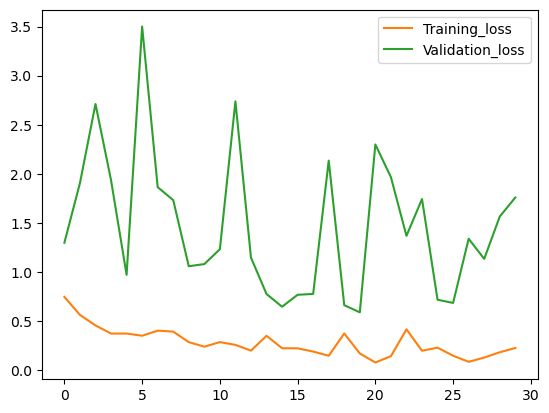

In [49]:
accuracy = history.history['acc']
val_accuracy  = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, loss, 'C1', label = 'Training_loss')
plt.plot(epochs, val_loss, 'C2', label = 'Validation_loss')
plt.legend()

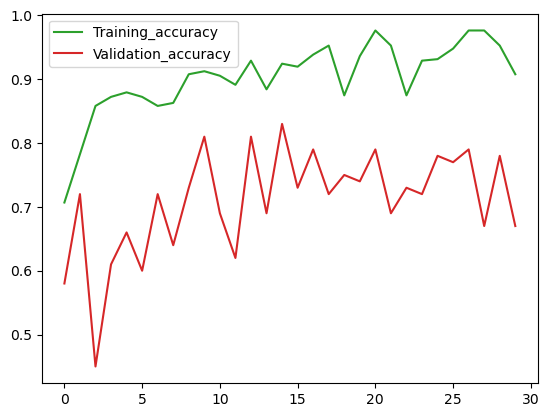

In [50]:
plt.plot(epochs, accuracy, 'C2', label = 'Training_accuracy')
plt.plot(epochs, val_accuracy, 'C3', label = 'Validation_accuracy')
plt.legend()

In [67]:
model.load_weights('weights.hdf5')

In [68]:
test_directory = 'Chest_X_Ray_project_data/Test'

test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size = 4, directory= test_directory, shuffle= True, target_size=(256,256), class_mode= 'categorical')

evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

Found 40 images belonging to 4 classes.


C:\Users\HP\AppData\Local\Temp\ipykernel_136\1761965567.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose =1)


10/10 [==============================] - 4s 341ms/step - loss: 1.0937 - acc: 0.7250
Accuracy Test : 0.7250000238418579


In [69]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import cv2
prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory,str(i))):
    img= cv2.imread(os.path.join(test_directory,str(i),item))#Basically convert .jpeg image in array
    img = cv2.resize(img,(256,256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1,256,256,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)
pass

1/1 [==============================] - 0s 140ms/step


In [70]:
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score)) #Only for 40 images
#it is different from Accuracy Test caculated aboe in sense that here we use Sklearn library to calculate it

Test Accuracy : 0.7


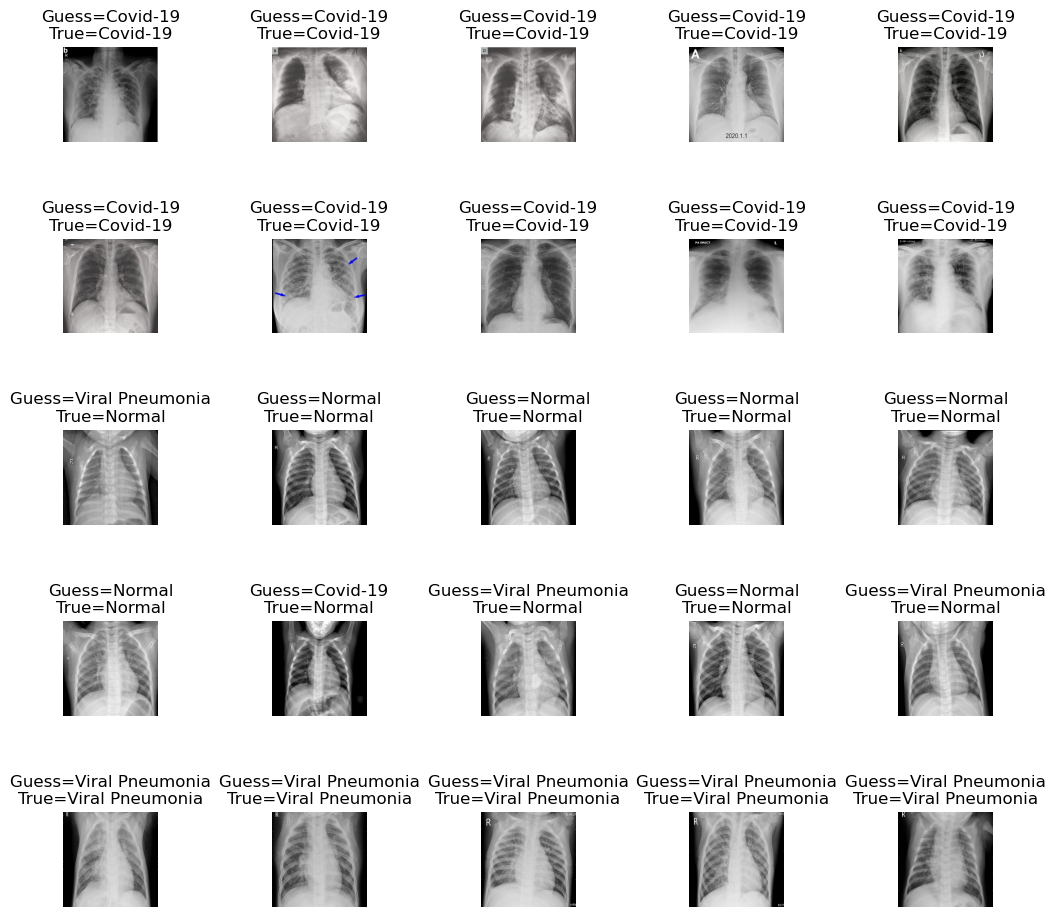

In [71]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2) 

In [72]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.75      0.60      0.67        10
           2       0.47      0.70      0.56        10
           3       1.00      0.50      0.67        10

    accuracy                           0.70        40
   macro avg       0.76      0.70      0.70        40
weighted avg       0.76      0.70      0.70        40



Text(0.5, 1.0, 'Confusion_matrix')

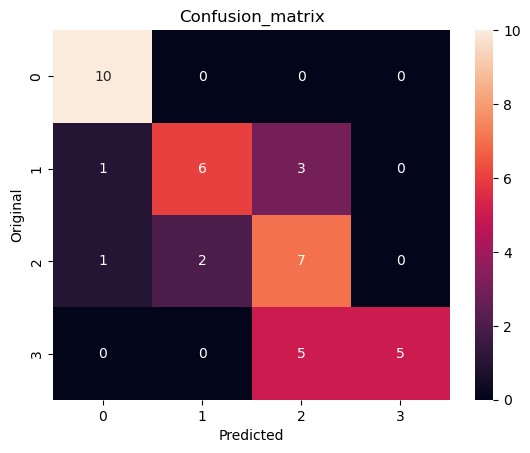

In [73]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')